In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate

from sgmrc.sgmcoint.common import adf
from sgmrc.sgmcoint.space import johansen
from sgmrc.sgmcoint.simulation import dgp2
from sgmarb.data import clean_df

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

# Preliminary example:

In [205]:
def get_splined(path, interval=10):
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df.timestamp, unit='ms')
    df = clean_df(df)

    df['elapsed'] = df.index.values - df.index.values[0]
    df['elapsed_seconds'] = df['elapsed'].astype(int) / 1000000000

    time_range = np.arange(0, df.elapsed_seconds.max(), 10)
    tgt_interpolated = interpolate.interp1d(df.elapsed_seconds, (df.bp1 + df.lp1) / 2., kind='zero')(time_range)

    return interpolate.UnivariateSpline(time_range, tgt_interpolated, k=3, s=1)(time_range)

In [206]:
mkt1 = get_splined('/home/tspooner/.oddscache/odds_T-EENP2600988-FT12-A.BF.csv.gz')
mkt2 = get_splined('/home/tspooner/.oddscache/odds_T-EENP2600988-FT12-B.BF.csv.gz')

min_idx = min(mkt1.shape[0], mkt2.shape[0])
mkt1 = mkt1[:min_idx]
mkt2 = mkt2[:min_idx]

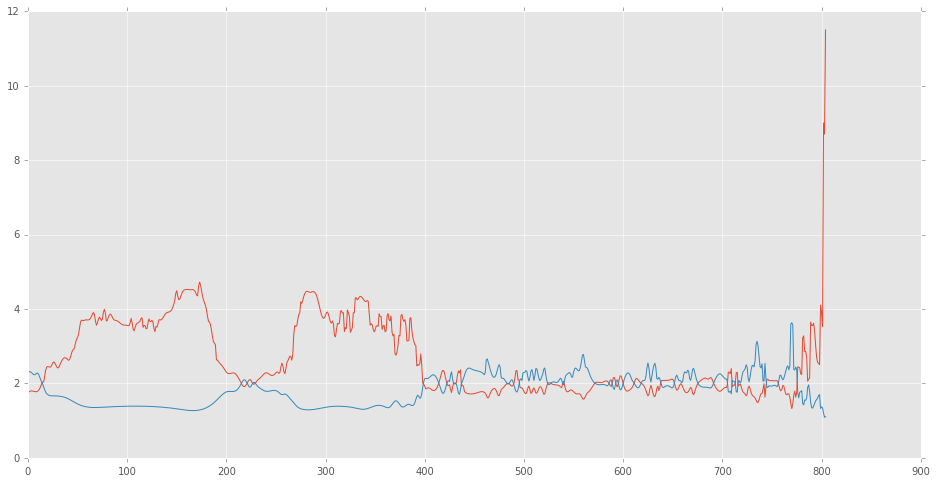

In [9]:
plt.plot(mkt1)
plt.plot(mkt2)

In [10]:
X = np.vstack([mkt1, mkt2]).T

In [11]:
adf(X[:, 0]), adf(X[:, 1])

(True, True)

In [12]:
coint_space = johansen(X, 1)
coint_space /= abs(coint_space[0, 0]) + abs(coint_space[1, 0])

coint_space

array([[ 0.42941582],
       [-0.57058418]])

In [13]:
loc_spread = np.dot(coint_space.T, X.T)
demean_spread = (loc_spread.T - np.mean(loc_spread, axis=1)) / np.std(loc_spread, axis=1)

In [14]:
adf(demean_spread[:, 0])

True

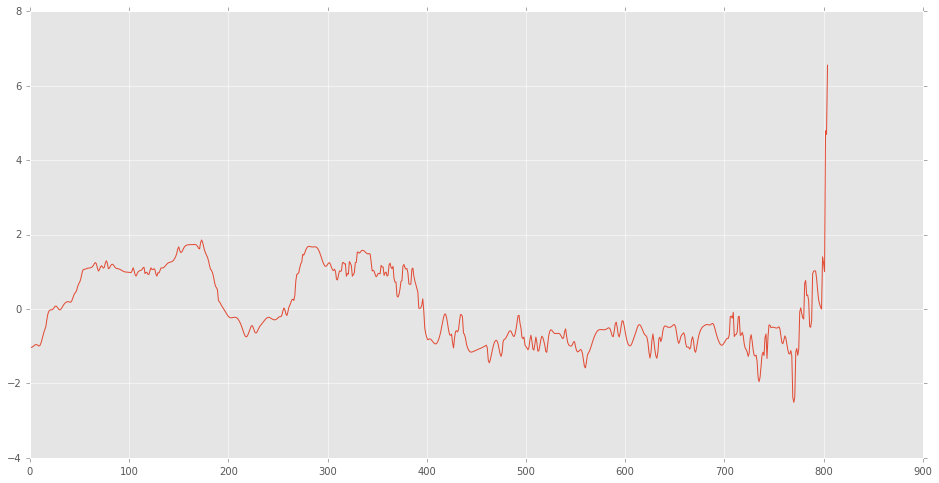

In [15]:
_ = plt.plot(demean_spread)

### Backtest (cheating here since we have a lookahead bias when de-meaning the spread series):

In [16]:
def to_spread(X, b):
    loc_spread = np.dot(b.T, X.T)
    demean_spread = (loc_spread.T - np.mean(loc_spread, axis=1)) / np.std(loc_spread, axis=1)

    return demean_spread.T

In [17]:
def backtest(X, b, risk=0.25):
    spread_series = to_spread(X, b)

    returns = np.diff(spread_series)
    returns[np.absolute(spread_series[0:, 1:]) < risk] = 0.0
    returns[spread_series[0:, 1:] < -risk] *= -1

    return returns

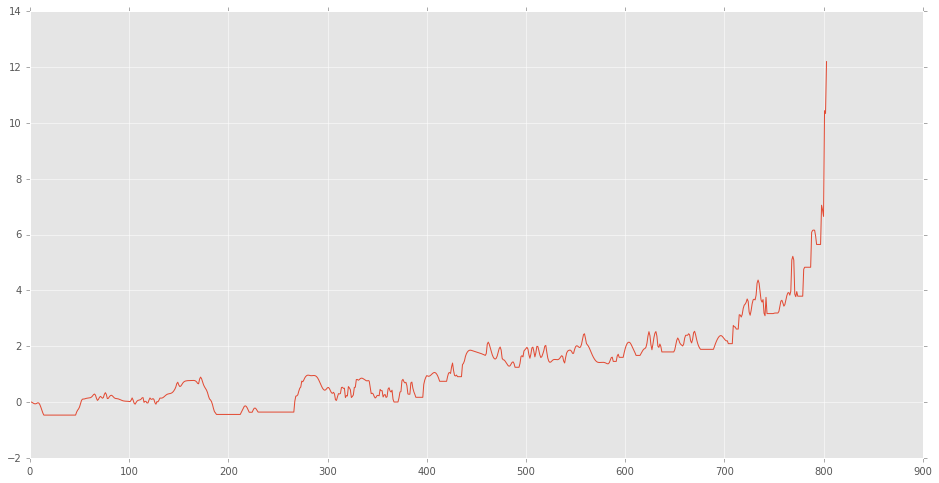

In [18]:
plt.plot(backtest(X, coint_space, 0.5).cumsum())

# Synthetic data test:

In [19]:
beta, data = dgp2(2, 1, 0.9).values()

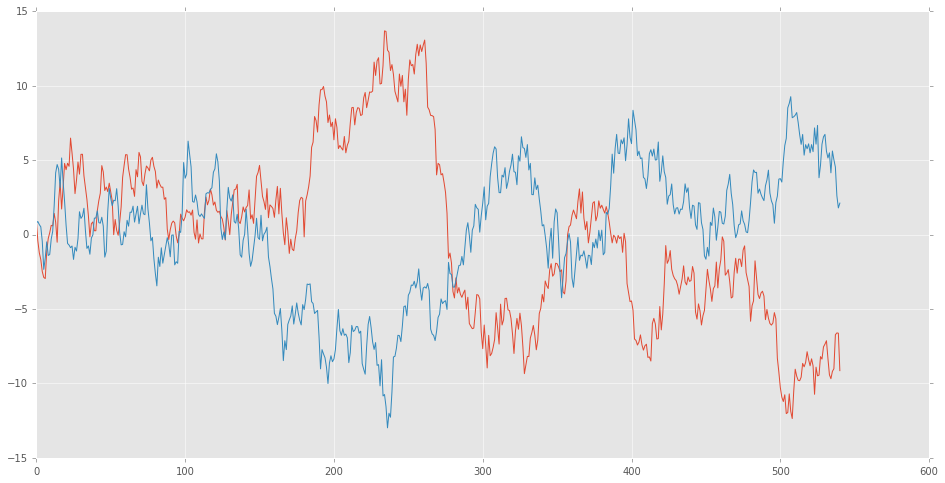

In [20]:
plt.plot(data)

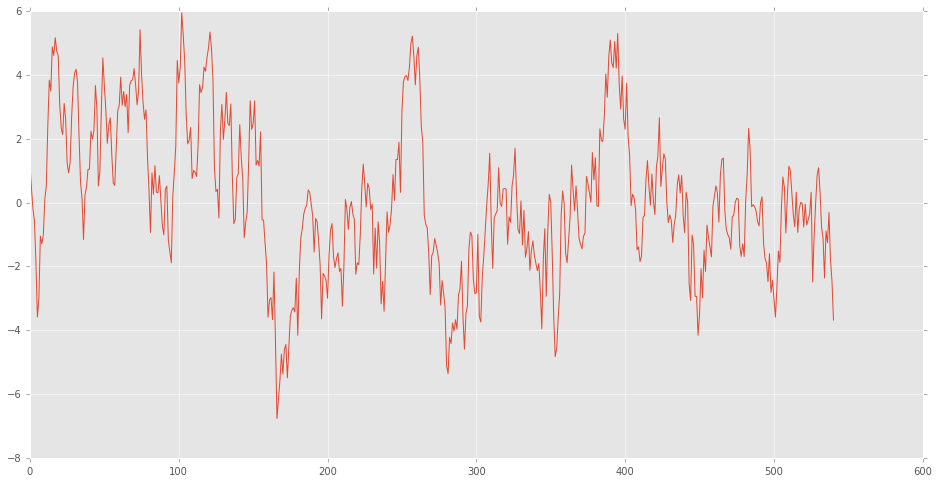

In [21]:
spread_series = np.dot(beta.T, data.T).T
plt.plot(spread_series)

In [22]:
adf(spread_series.ravel())

False

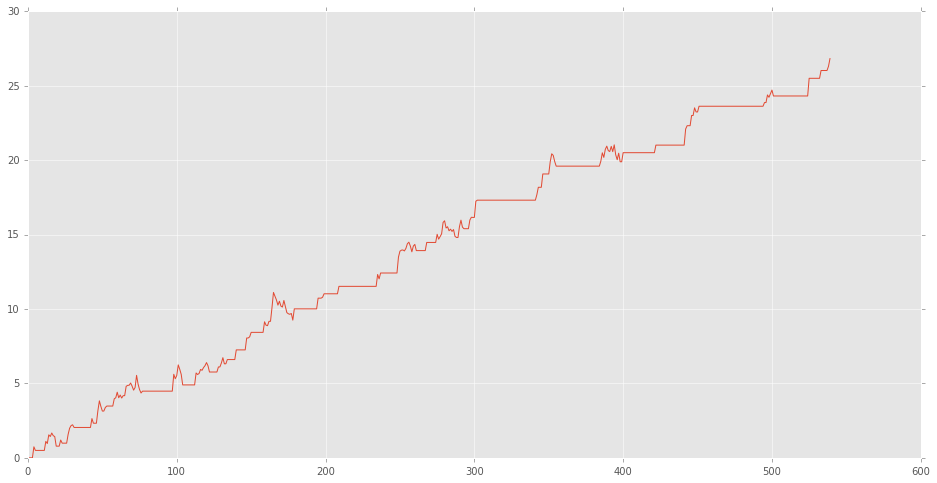

In [23]:
plt.plot(backtest(data, beta, 1).cumsum())

# Backtesting proper (rolling window):

In [24]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [145]:
SLW = 200
idx = 300

roll_X1 = rolling_window(X[:, 0], SLW)
roll_X2 = rolling_window(X[:, 1], SLW)

Y = np.array([roll_X1[idx], roll_X2[idx]])

beta = johansen(Y.T, 1)
beta /= np.sum(np.abs(beta))

spd = np.dot(beta.T, Y)

In [146]:
spd_norm = spd[0] / np.std(spd[0])

Is stationary: False


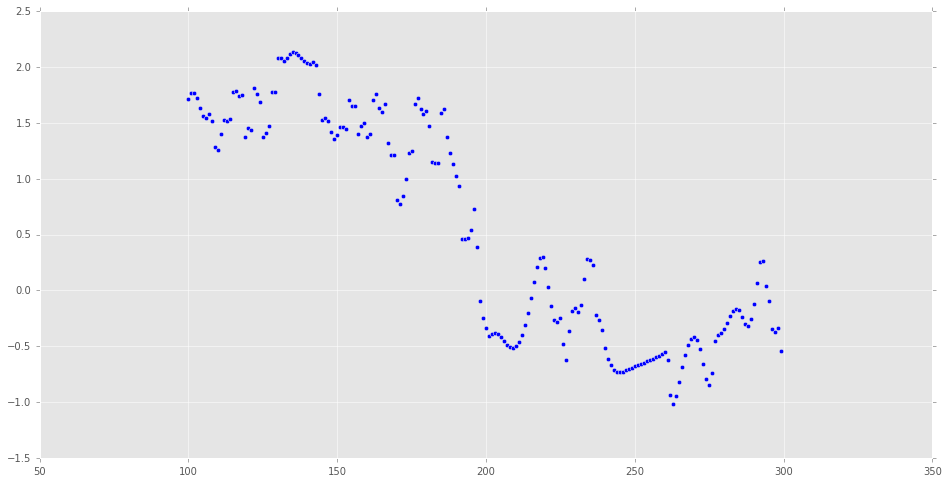

In [147]:
plt.scatter(np.arange(idx-SLW, idx), spd_norm)
print 'Is stationary:', not adf(spd_norm)

### Cochrane-Orcutt (well not for now as there's no python package for it):

In [148]:
SPL = 10

In [149]:
x = np.arange(idx-SLW, idx, SPL).astype(np.float)
xtr = (x - np.min(x)) / SLW

y = spd[0, range(0, SLW, SPL)]

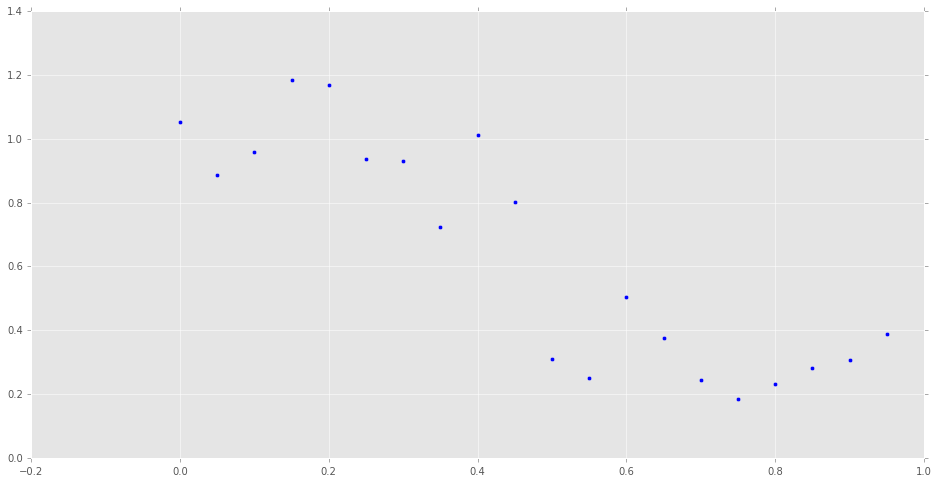

In [154]:
_ = plt.scatter(xtr, y)

In [151]:
min_y = np.min(y)
max_y = np.max(y)

if (np.abs(min_y - max_y) > 0):
    y = y / (max_y - min_y) - min_y

In [200]:
res.pvalues

array([  2.45494921e-11,   7.04683828e-07])

In [185]:
import statsmodels.api as sm

xfit = sm.add_constant(xtr)

reg = sm.OLS(y, xfit)
res = reg.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     55.04
Date:                Tue, 03 Oct 2017   Prob (F-statistic):           7.05e-07
Time:                        15:54:56   Log-Likelihood:                 6.6766
No. Observations:                  20   AIC:                            -9.353
Df Residuals:                      18   BIC:                            -7.362
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.1361      0.079     14.432      0.000         0.971     1.301
x1            -1.0511      0.142     -7.419      0.000        -1.349    -0.753
==============================================================================
Omnibus:                        0.813   Durbin-Watson:                   1.083
Prob(Omnibus):                  0.666   Jarque-Bera (JB):                0.692
Skew:                          -0.026   Prob(JB):                        0.708
Kurtosis:                       2.090   Cond. No.                         4.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([ 1.1360801 , -1.05108981])

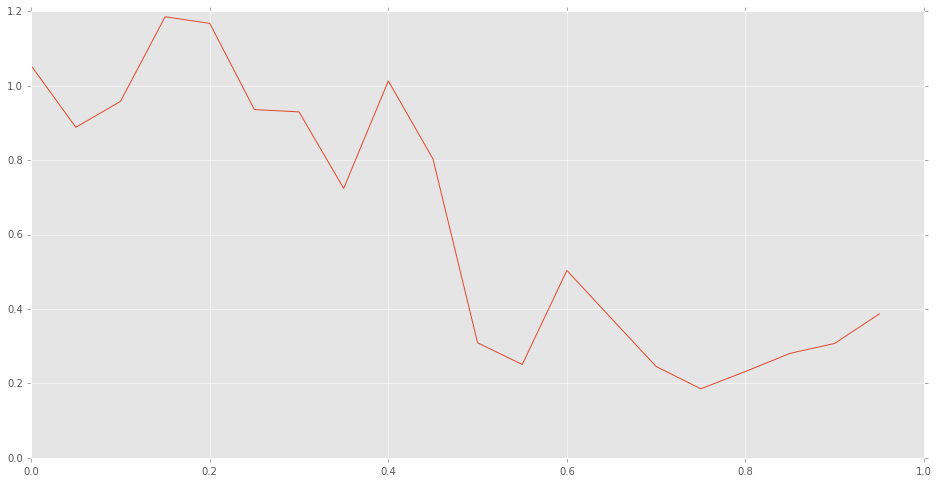

In [194]:
plt.plot(xtr, y)